# Prepare Env and Dataset

In [ ]:
!wget https://huggingface.co/datasets/Boese0601/CSCI535_HW3_data/resolve/main/archive.zip

--2025-03-23 01:51:17--  https://huggingface.co/datasets/Boese0601/CSCI535_HW3_data/resolve/main/archive.zip
Resolving huggingface.co (huggingface.co)... 3.163.189.90, 3.163.189.37, 3.163.189.74, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.90|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/8c/f8/8cf810f67a7acf502fb246b721100ca55e1086207178342d0cec0953ba0c6aa4/607ba8de794161b04002ff5bf1c50ca9cbc7e232c2abbd5fdc760aaa9f44b93b?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27archive.zip%3B+filename%3D%22archive.zip%22%3B&response-content-type=application%2Fzip&Expires=1742698277&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MjY5ODI3N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzhjL2Y4LzhjZjgxMGY2N2E3YWNmNTAyZmIyNDZiNzIxMTAwY2E1NWUxMDg2MjA3MTc4MzQyZDBjZWMwOTUzYmEwYzZhYTQvNjA3YmE4ZGU3OTQxNjFiMDQwMDJmZjViZjFjNTBjYTljYmM3ZTIzMmMyYWJiZDVmZG

In [ ]:
%ls

archive.zip  sample_data/


In [ ]:
import zipfile
import os
for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, "r") as zip_file:
            zip_file.extractall()
        os.remove(file)

In [ ]:
%ls

fer20131.csv  fer2013.bib  ferSubmission.csv  README  sample_data/


In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.3
    Uninstalling protobuf-5.29.3:
      Successfully uninstalled protobuf-5.29.3
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.


In [ ]:
!pip install --upgrade numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 62.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.


# Importing necessary libraries

In [ ]:
# imports
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import random

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.utils import make_grid

import mediapipe as mp

from tqdm.notebook import tqdm
tqdm.pandas()

In [ ]:
dataset=pd.read_csv("fer20131.csv")

In [ ]:
dataset["emotion"].value_counts(normalize=True)*100

,proportion
emotion,
3,25.048068
6,17.270878
4,16.933709
2,14.269791
0,13.801655
5,11.151671
1,1.524229


In [ ]:
train_df = dataset[dataset["Usage"] == "Training"]
val_df = dataset[dataset["Usage"] == "PublicTest"]
test_df = dataset[dataset["Usage"] == "PrivateTest"]

# Converting into tensor-Dataset

In [ ]:
class FER2018Dataset(Dataset):
    '''
        Parse raw data to form a Dataset of (X, y).
    '''
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.classes = {0: 'Angry',
                        1: 'Disgust',
                        2: 'Fear',
                        3: 'Happy',
                        4: 'Sad',
                        5: 'Surprise',
                        6: 'Neutral'
                       }

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        label = int(row['emotion'])
        img = np.array(row["pixels"].split(' '), dtype=np.uint8).reshape(48, 48)
        img = np.stack([img] * 3, axis=2) # make a 3-channel RGB image from a grayscale


        if self.transform:
            img = self.transform(img)

        return {
                'image': torch.tensor(img, dtype=torch.float),
                'label': torch.tensor(label, dtype=torch.long)
            }

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip()
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = FER2018Dataset(train_df, train_transform)
val_dataset = FER2018Dataset(val_df, test_transform)
test_dataset = FER2018Dataset(test_df, test_transform)

In [ ]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size, num_workers=1, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=1, pin_memory=True)

# Connect if Gpu is available

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
!nvidia-smi

Sun Mar 23 01:52:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Visulization of Images

  0%|          | 0/7 [00:00<?, ?it/s]

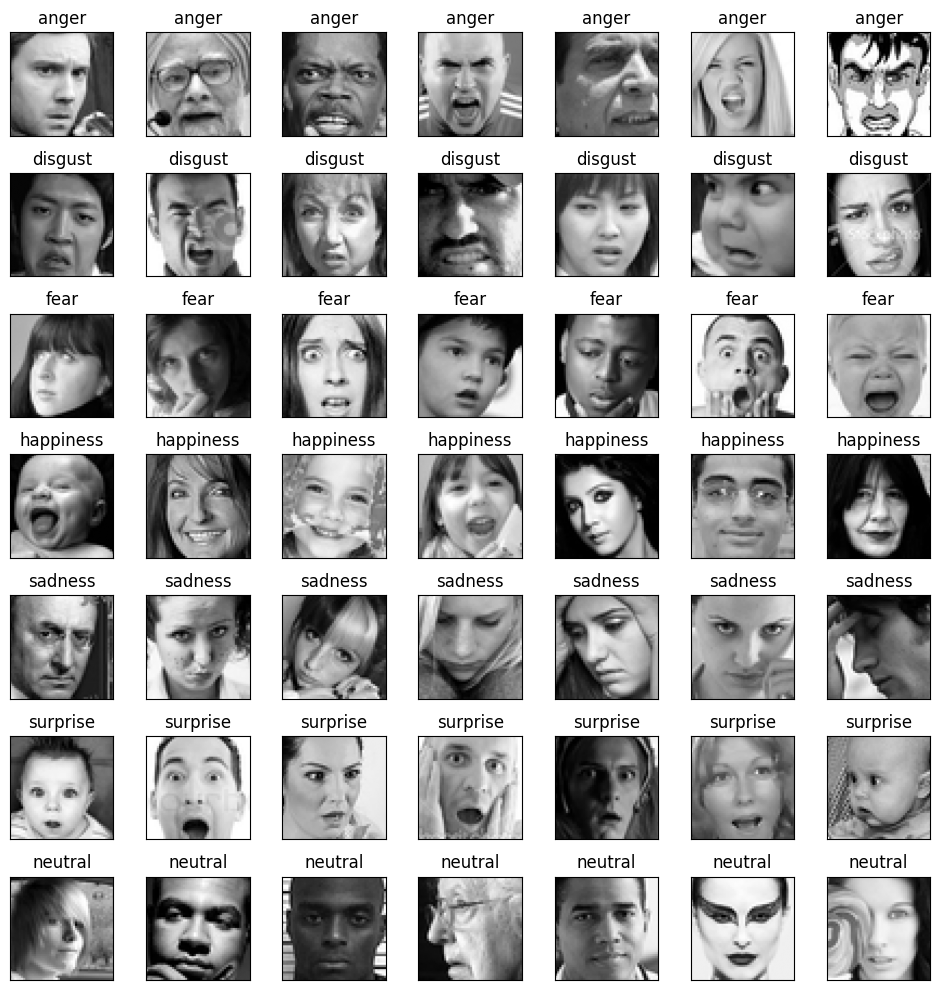

In [ ]:
import cv2
fig = plt.figure(1, (10, 10))
k = 0
emotions = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
for label in tqdm(sorted(dataset.emotion.unique())):
    for j in range(7):
        px = dataset[dataset.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        px = cv2.resize(px, dsize=(192, 192), interpolation=cv2.INTER_NEAREST)
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions[label])
        plt.tight_layout()

# Landmark Detection with MediaPipe

In [ ]:
import cv2
def detect_mediapipe(image):
  mp_face_detection = mp.solutions.face_detection
  mp_face_mesh = mp.solutions.face_mesh
  # help(mp_face_detection.FaceDetection)


  mp_drawing = mp.solutions.drawing_utils
  drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
  mp_drawing_styles = mp.solutions.drawing_styles

  FACEMESH_LIPS = [(61, 146), (146, 91), (91, 181), (181, 84), (84, 17),
                            (17, 314), (314, 405), (405, 321), (321, 375),
                            (375, 291), (61, 185), (185, 40), (40, 39), (39, 37),
                            (37, 0), (0, 267),
                            (267, 269), (269, 270), (270, 409), (409, 291),
                            (78, 95), (95, 88), (88, 178), (178, 87), (87, 14),
                            (14, 317), (317, 402), (402, 318), (318, 324),
                            (324, 308), (78, 191), (191, 80), (80, 81), (81, 82),
                            (82, 13), (13, 312), (312, 311), (311, 310),
                            (310, 415), (415, 308)]
  FACEMESH_LEFT_EYE = [(263, 249), (249, 390), (390, 373), (373, 374),
                                (374, 380), (380, 381), (381, 382), (382, 362),
                                (263, 466), (466, 388), (388, 387), (387, 386),
                                (386, 385), (385, 384), (384, 398), (398, 362)]


  FACEMESH_RIGHT_EYE = [(33, 7), (7, 163), (163, 144), (144, 145),
                                  (145, 153), (153, 154), (154, 155), (155, 133),
                                  (33, 246), (246, 161), (161, 160), (160, 159),
                                  (159, 158), (158, 157), (157, 173), (173, 133)]
  Left_eye = []
  Right_eye = []
  Lips = []
  for (x,y) in FACEMESH_LEFT_EYE:
    if x not in Left_eye:
      Left_eye.append(x)
    if y not in Left_eye:
      Left_eye.append(y)
  # print(Left_eye)
  # print(FACEMESH_LEFT_EYE)

  for (x,y) in FACEMESH_RIGHT_EYE:
    if x not in Right_eye:
      Right_eye.append(x)
    if y not in Right_eye:
      Right_eye.append(y)
  # print(Right_eye)
  # print(FACEMESH_RIGHT_EYE)

  for (x,y) in FACEMESH_LIPS:
    if x not in Lips:
      Lips.append(x)
    if y not in Lips:
      Lips.append(y)
  # print(Lips)
  # print(FACEMESH_LIPS)


  with mp_face_mesh.FaceMesh(
      static_image_mode=True,
      refine_landmarks=True,
      max_num_faces=2,
      min_detection_confidence=0.5) as face_mesh:
      # Convert the Gray Scale image to RGB and process it with MediaPipe Face Mesh.
      image = cv2.resize(image, dsize=(192, 192), interpolation=cv2.INTER_NEAREST)
      results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
      # if results == None:
        # continue
        # print("No Face deteced for this image.")
      # Draw face landmarks of each face.
      # print(f'Face landmarks of {name}:')
      if not results.multi_face_landmarks:
        # print("No landmark deteced for this image.")
        return None
      annotated_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

      # print(len(results.multi_face_landmarks)) 1
      for face_landmarks in results.multi_face_landmarks:
          # print(face_landmarks)
          mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
          mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
          mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_iris_connections_style())

          lm_left_eye_x = []
          lm_left_eye_y = []
          lm_right_eye_x = []
          lm_right_eye_y = []
          lm_lips_x = []
          lm_lips_y = []
          for i in Left_eye:
            lm_left_eye_x.append(face_landmarks.landmark[i].x)
            lm_left_eye_y.append(face_landmarks.landmark[i].y)
          for i in Right_eye:
            lm_right_eye_x.append(face_landmarks.landmark[i].x)
            lm_right_eye_y.append(face_landmarks.landmark[i].y)
          for i in Lips:
            lm_lips_x.append(face_landmarks.landmark[i].x)
            lm_lips_y.append(face_landmarks.landmark[i].y)
          lm_x = lm_left_eye_x + lm_right_eye_x + lm_lips_x
          lm_y = lm_left_eye_y + lm_right_eye_y + lm_lips_y
          landmark = np.array([lm_x,lm_y]).T
          # np.save(land_path, landmark)



  return annotated_image, landmark




  0%|          | 0/7 [00:00<?, ?it/s]

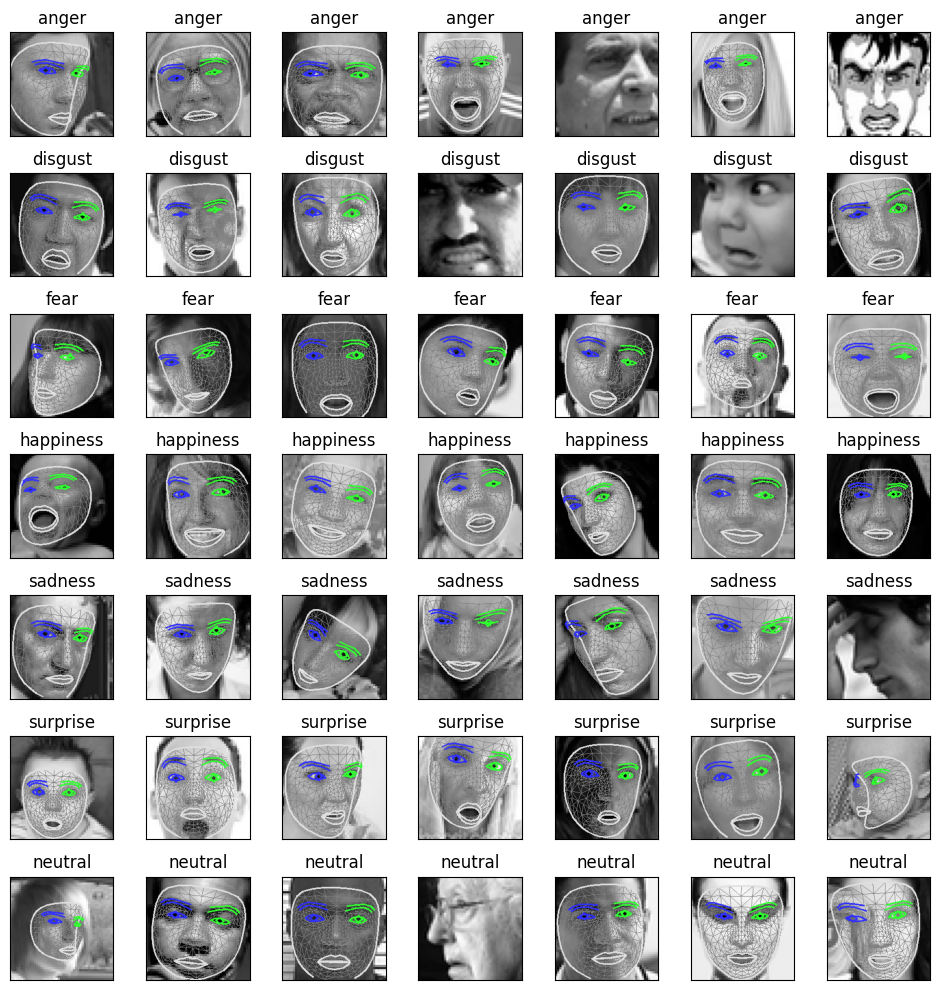

In [ ]:
fig = plt.figure(1, (10, 10))
k = 0
emotions = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
for label in tqdm(sorted(dataset.emotion.unique())):
    for j in range(7):
        px = dataset[dataset.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48, 1).astype('uint8')
        # print(px.shape)
        try:
          px, _ = detect_mediapipe(px)
          k += 1
          ax = plt.subplot(7, 7, k)
          ax.imshow(px)
          ax.set_xticks([])
          ax.set_yticks([])
          ax.set_title(emotions[label])
          plt.tight_layout()
        except:
          px = px
          k += 1
          ax = plt.subplot(7, 7, k)
          ax.imshow(px,cmap="gray")
          ax.set_xticks([])
          ax.set_yticks([])
          ax.set_title(emotions[label])
          plt.tight_layout()

# Prepare you landmark ground truth and dataloader using mediapipe

In [ ]:
### Your code here
class FacialLandmarkDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.landmarks = []
        self.valid_indices = []

        # Process each image and extract landmarks
        for idx in tqdm(range(len(df))):
            row = df.iloc[idx]
            img = np.array(row["pixels"].split(' '), dtype=np.uint8).reshape(48, 48, 1).astype('uint8')

            try:
                _, landmark = detect_mediapipe(img)
                # Extract only the 4 required landmarks
                # Left eye center (average of left eye landmarks)
                left_eye_center_x = np.mean(landmark[:16, 0])
                left_eye_center_y = np.mean(landmark[:16, 1])
                # Right eye center (average of right eye landmarks)
                right_eye_center_x = np.mean(landmark[16:32, 0])
                right_eye_center_y = np.mean(landmark[16:32, 1])

                # Left lip corner (using the leftmost point of lips)
                lips_x_sorted_indices = np.argsort(landmark[32:, 0])
                left_lip_corner_x = landmark[32:, 0][lips_x_sorted_indices[0]]
                left_lip_corner_y = landmark[32:, 1][lips_x_sorted_indices[0]]
                # Right lip corner (using the rightmost point of lips)
                right_lip_corner_x = landmark[32:, 0][lips_x_sorted_indices[-1]]
                right_lip_corner_y = landmark[32:, 1][lips_x_sorted_indices[-1]]

                landmark_points = np.array([
                    left_eye_center_x, left_eye_center_y,
                    right_eye_center_x, right_eye_center_y,
                    left_lip_corner_x, left_lip_corner_y,
                    right_lip_corner_x, right_lip_corner_y
                ])

                self.landmarks.append(landmark_points)
                self.valid_indices.append(idx)
            except:
                # Skip images where landmark detection fails
                continue

        print(f"Successfully processed {len(self.valid_indices)} out of {len(df)} images") # Show how many processed

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        df_idx = self.valid_indices[idx]
        row = self.df.iloc[df_idx]

        # Get image with 3 channel
        img = np.array(row["pixels"].split(' '), dtype=np.uint8).reshape(48, 48)
        img = np.stack([img] * 3, axis=2)  # Make a 3-channel RGB image from grayscale

        if self.transform:
            img = self.transform(img)

        # Get landmark
        landmark = self.landmarks[idx]

        return {
            'image': torch.tensor(img, dtype=torch.float),
            'landmark': torch.tensor(landmark, dtype=torch.float)
        }

# Create datasets
landmark_train_dataset = FacialLandmarkDataset(train_df, test_transform)  # No augmentation for landmarks
landmark_val_dataset = FacialLandmarkDataset(val_df, test_transform)
landmark_test_dataset = FacialLandmarkDataset(test_df, test_transform)


  0%|          | 0/28709 [00:00<?, ?it/s]

Successfully processed 25462 out of 28709 images


  0%|          | 0/3589 [00:00<?, ?it/s]

Successfully processed 3188 out of 3589 images


  0%|          | 0/3589 [00:00<?, ?it/s]

Successfully processed 3150 out of 3589 images


In [ ]:
# Create dataloaders
batch_size = 64
landmark_train_dataloader = DataLoader(landmark_train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
landmark_val_dataloader = DataLoader(landmark_val_dataset, batch_size, num_workers=4, pin_memory=True)
landmark_test_dataloader = DataLoader(landmark_test_dataset, batch_size, num_workers=4, pin_memory=True)

# Define Pytorch Model for Facial Landmark Detection

In [ ]:
#### Your model code here

# Model for Facial Landmark Detection
class LandmarkDetectionModel(nn.Module):
    def __init__(self, num_landmarks=4*2):  # 4 landmarks (x,y) coordinates
        super(LandmarkDetectionModel, self).__init__()
        # Load pre-trained ResNet18
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Modify the first convolutional layer to accept grayscale images (1 channel)
        # by duplicating weights of the first layer
        original_weight = self.resnet.conv1.weight.clone()
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify the final fully connected layer for landmark regression
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_landmarks)  # Output 8 values: (x,y) for each of the 4 landmarks
        )

    def forward(self, x):
        return self.resnet(x)

# Landmark Detection Model Training

In [ ]:
### Your traning code here

# Landmark Detection Model Training

landmark_model = LandmarkDetectionModel().to(device)
landmark_loss_fn = nn.MSELoss() # Using MSE Loss
landmark_optimizer = optim.AdamW(landmark_model.parameters(), lr=0.0001, weight_decay=5e-4) # Optimiser Adam with weight decay of 5e-4
landmark_scheduler = optim.lr_scheduler.ReduceLROnPlateau(landmark_optimizer, 'min', patience=2)  # Set a momentum

def train_landmark_model(model, dataloader, optimizer, loss_fn):
    model.train()
    train_running_loss = 0.0

    for data in tqdm(dataloader,desc="Training",total=len(dataloader)):
        images, landmarks = data['image'].to(device), data['landmark'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, landmarks)
        train_running_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / len(dataloader)
    return train_loss

# Validation function
def validate_landmark_model(model, dataloader, loss_fn):
    model.eval()
    valid_running_loss = 0.0

    with torch.no_grad():
        for data in tqdm(dataloader,desc="Validation", total=len(dataloader)):
            images, landmarks = data['image'].to(device), data['landmark'].to(device)

            outputs = model(images)
            loss = loss_fn(outputs, landmarks)
            valid_running_loss += loss.item()

    valid_loss = valid_running_loss / len(dataloader)
    return valid_loss

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 70.6MB/s]


In [ ]:
# Training loop
landmark_epochs = 25
landmark_train_losses = []
landmark_val_losses = []

best_val_loss = float('inf')
best_model_state = None

for epoch in range(1, landmark_epochs + 1):
    train_epoch_loss = train_landmark_model(landmark_model, landmark_train_dataloader, landmark_optimizer, landmark_loss_fn)
    val_epoch_loss = validate_landmark_model(landmark_model, landmark_val_dataloader, landmark_loss_fn)

    landmark_scheduler.step(val_epoch_loss)

    landmark_train_losses.append(train_epoch_loss)
    landmark_val_losses.append(val_epoch_loss)

    print(f'Epoch: {epoch}, Train loss: {train_epoch_loss:.6f}, Val loss: {val_epoch_loss:.6f}')

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        best_model_state = landmark_model.state_dict().copy()
        print(f"Saved best model with val loss: {best_val_loss:.6f}")

Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, Train loss: 0.030564, Val loss: 0.005669
Saved best model with val loss: 0.005669


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, Train loss: 0.011301, Val loss: 0.005059
Saved best model with val loss: 0.005059


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 3, Train loss: 0.009201, Val loss: 0.004610
Saved best model with val loss: 0.004610


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 4, Train loss: 0.007848, Val loss: 0.003785
Saved best model with val loss: 0.003785


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 5, Train loss: 0.006847, Val loss: 0.003462
Saved best model with val loss: 0.003462


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 6, Train loss: 0.006125, Val loss: 0.002974
Saved best model with val loss: 0.002974


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 7, Train loss: 0.005489, Val loss: 0.002950
Saved best model with val loss: 0.002950


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 8, Train loss: 0.004956, Val loss: 0.002653
Saved best model with val loss: 0.002653


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 9, Train loss: 0.004561, Val loss: 0.002160
Saved best model with val loss: 0.002160


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 10, Train loss: 0.004416, Val loss: 0.002239


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 11, Train loss: 0.003997, Val loss: 0.002289


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 12, Train loss: 0.003782, Val loss: 0.002047
Saved best model with val loss: 0.002047


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 13, Train loss: 0.004176, Val loss: 0.002181


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 14, Train loss: 0.003622, Val loss: 0.001774
Saved best model with val loss: 0.001774


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 15, Train loss: 0.003362, Val loss: 0.001607
Saved best model with val loss: 0.001607


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 16, Train loss: 0.003220, Val loss: 0.001955


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 17, Train loss: 0.003008, Val loss: 0.001664


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 18, Train loss: 0.002956, Val loss: 0.001770


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 19, Train loss: 0.002581, Val loss: 0.001412
Saved best model with val loss: 0.001412


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 20, Train loss: 0.002480, Val loss: 0.001339
Saved best model with val loss: 0.001339


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 21, Train loss: 0.002438, Val loss: 0.001367


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 22, Train loss: 0.002441, Val loss: 0.001289
Saved best model with val loss: 0.001289


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 23, Train loss: 0.002357, Val loss: 0.001480


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 24, Train loss: 0.002332, Val loss: 0.001375


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 25, Train loss: 0.002329, Val loss: 0.001304


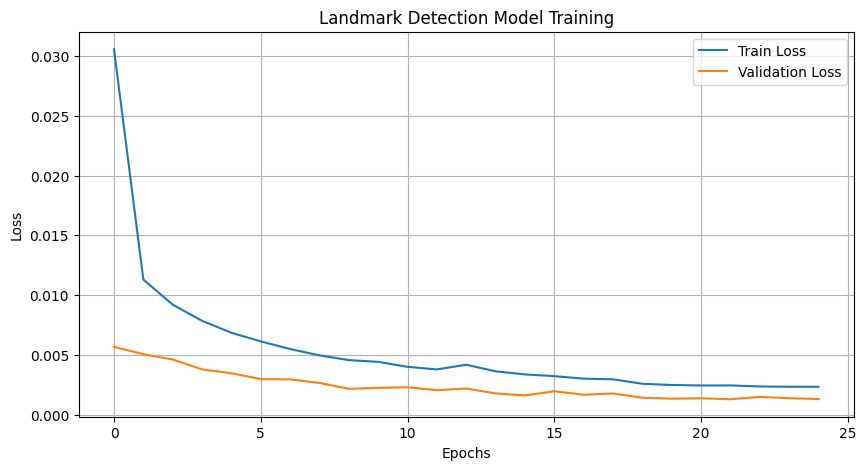

In [ ]:
# Load the best model
landmark_model.load_state_dict(best_model_state)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(landmark_train_losses, label='Train Loss')
plt.plot(landmark_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Landmark Detection Model Training')
plt.legend()
plt.grid(True)
plt.show()

# Test your Landmark Detection Model on Test Set and Report Results

In [ ]:
### Your inference code here

def test_landmark_model(model, dataloader):
    model.eval()
    all_errors = []

    with torch.no_grad():
        for data in tqdm(dataloader, desc="Testing landmark model...", total=len(dataloader)):
            images, landmarks = data['image'].to(device), data['landmark'].to(device)

            # Forward pass
            outputs = model(images)

            # Calculate Euclidean distance (L1) error for each landmark
            for i in range(len(outputs)):
                pred_landmarks = outputs[i].cpu().numpy()
                true_landmarks = landmarks[i].cpu().numpy()

                # Calculate errors for each landmark pair
                errors = []
                for j in range(0, 8, 2):  # Process each (x,y) pair
                    pred_x, pred_y = pred_landmarks[j], pred_landmarks[j+1]
                    true_x, true_y = true_landmarks[j], true_landmarks[j+1]

                    # Euclidean distance
                    error = np.sqrt((pred_x - true_x)**2 + (pred_y - true_y)**2)
                    errors.append(error)

                all_errors.append(errors)

    # Convert to numpy array for analysis
    all_errors = np.array(all_errors)

    # Calculate average error per landmark
    avg_errors = np.mean(all_errors, axis=0)
    overall_avg_error = np.mean(all_errors)

    return overall_avg_error, avg_errors



In [ ]:
overall_error, landmark_errors = test_landmark_model(landmark_model, landmark_test_dataloader)

print(f"Overall average landmark error: {overall_error:.4f}")
print(f"Left eye center error: {landmark_errors[0]:.4f}")
print(f"Right eye center error: {landmark_errors[1]:.4f}")
print(f"Left lip corner error: {landmark_errors[2]:.4f}")
print(f"Right lip corner error: {landmark_errors[3]:.4f}")


Testing landmark model...:   0%|          | 0/50 [00:00<?, ?it/s]

Overall average landmark error: 0.0386
Left eye center error: 0.0346
Right eye center error: 0.0342
Left lip corner error: 0.0425
Right lip corner error: 0.0432


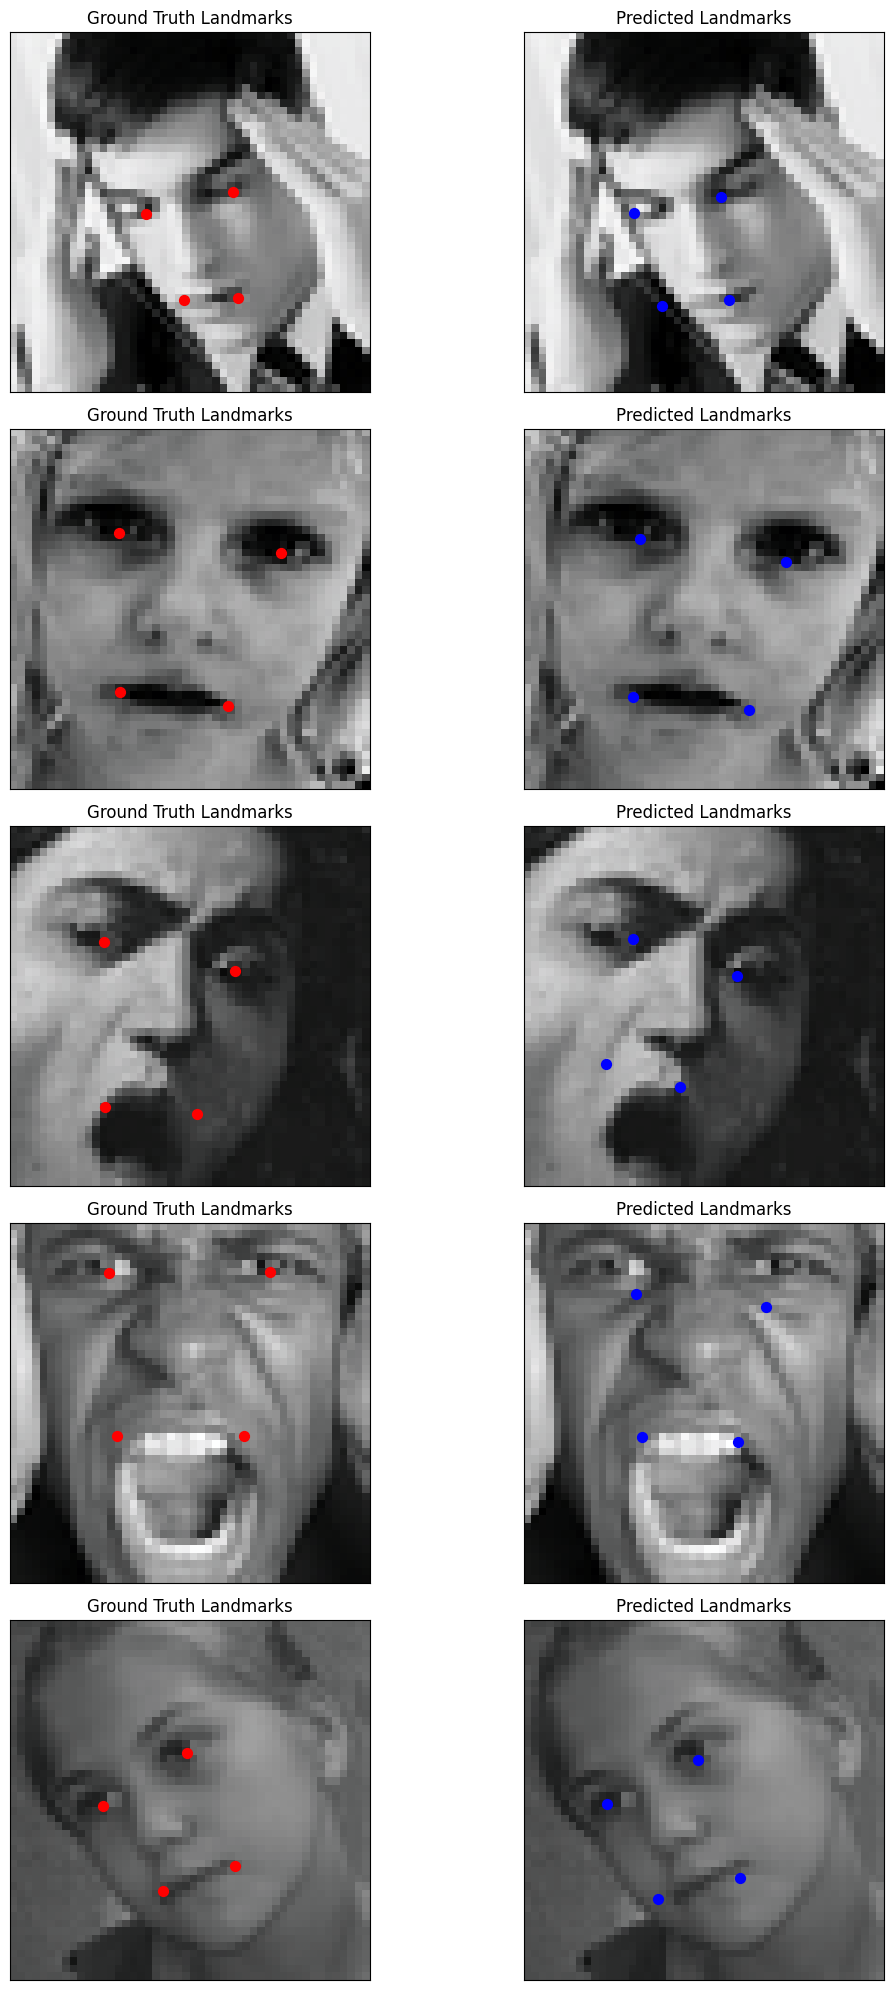

In [ ]:
def visualize_landmark_predictions(model, dataloader, num_samples=5):
    model.eval()

    # Get a batch of samples
    dataiter = iter(dataloader)
    data = next(dataiter)

    images = data['image'].to(device)
    true_landmarks = data['landmark'].cpu().numpy()

    # Get predictions
    with torch.no_grad():
        pred_landmarks = model(images).cpu().numpy()
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4*num_samples))

    for i in range(num_samples):
        if i >= len(images):
            break

        # Get the image
        img = images[i].permute(1, 2, 0).cpu().numpy()
        # Denormalize
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        # Plot ground truth
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Ground Truth Landmarks')
        # Plot ground truth landmarks
        for j in range(0, 8, 2):
            x, y = true_landmarks[i][j], true_landmarks[i][j+1]
            axes[i, 0].scatter(x * img.shape[1], y * img.shape[0], c='r', s=50)
        # Plot predictions
        axes[i, 1].imshow(img)
        axes[i, 1].set_title('Predicted Landmarks')
        # Plot predicted landmarks
        for j in range(0, 8, 2):
            x, y = pred_landmarks[i][j], pred_landmarks[i][j+1]
            axes[i, 1].scatter(x * img.shape[1], y * img.shape[0], c='b', s=50)

        # Remove axis ticks
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])

    plt.tight_layout()
    plt.show()

'''Let's try visualizing 5 samples against the ground truth and predictions to assess the model'''
visualize_landmark_predictions(landmark_model, landmark_test_dataloader, num_samples=5)

# Define Pytorch Model for Facial Expression Classification

In [ ]:
### Your model code here
# Define Pytorch Model for Facial Expression Classification
class EmotionClassificationModel(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionClassificationModel, self).__init__()

        # Load pre-trained ResNet18
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Modify first conv layer to handle grayscale images while utilizing pre-trained weights
        original_weight = self.resnet.conv1.weight.clone()
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        with torch.no_grad():
            self.resnet.conv1.weight = nn.Parameter(original_weight)

        # Modify the final fully connected layer for emotion classification
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.3),  # Increased dropout from 0.2 to 0.3
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),  # Uncommented the second dropout layer
            nn.Linear(256, num_classes)
        )
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global average pooling
            nn.Conv2d(512, 32, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(32, 512, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Extract intermediate features
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        att = self.attention(x)  # adding self attention
        x = x * att
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)

        return x


model = EmotionClassificationModel().to(device)
# Data Agumentation to train better
emotion_train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomRotation(25),  # Increased from 15 to 20 degrees ( Adjusting accordingly )
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Added scaling
    transforms.ColorJitter(brightness=0.3, contrast=0.3),  # Increased from 0.2 to 0.3 Contrast
    transforms.RandomErasing(p=0.2)  # Added random erasing to make the model better learn
])


In [ ]:
# Datasets
train_dataset = FER2018Dataset(train_df, emotion_train_transform)
val_dataset = FER2018Dataset(val_df, test_transform)
test_dataset = FER2018Dataset(test_df, test_transform)

# Dataloaders
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=4, pin_memory=True)

# Facial Expression Classification Model Training

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Enhanced training function with gradient clipping
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    train_running_loss = 0.0
    train_running_acc = 0.0

    for data in tqdm(dataloader, desc="Training: ", total=len(dataloader)):
        images, labels = data['image'].to("cuda"), data['label'].to("cuda")
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        train_running_loss += loss.clone().detach()
        train_running_acc += accuracy(outputs.clone().detach(), labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Add gradient clippin to prevent exploding gradients
        optimizer.step()

    train_loss = train_running_loss / len(dataloader)
    train_acc = train_running_acc / len(dataloader)

    return train_loss, train_acc

In [ ]:
# Validation function
def validate(model, dataloader, optimizer, loss_fn):
    model.eval()

    valid_running_loss = 0.0
    valid_running_acc = 0.0

    with torch.no_grad():
        for data in tqdm(dataloader, desc="Validating:", total=len(dataloader)):
            images, labels = data['image'].to(device), data['label'].to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            valid_running_loss += loss.clone().detach()
            valid_running_acc += accuracy(outputs.clone().detach(), labels)

    valid_loss = valid_running_loss / len(dataloader)
    valid_acc = valid_running_acc / len(dataloader)

    return valid_loss, valid_acc

In [ ]:
'''Tried to mitigate the problem of class imbalance by normalising'''
# Calculate class weights for imbalanced dataset
class_counts = train_df['emotion'].value_counts().sort_index().values
class_weights = torch.FloatTensor(1.0 / class_counts)
class_weights = class_weights / class_weights.sum() * len(class_weights)
class_weights = class_weights.to(device)

loss_function = nn.CrossEntropyLoss(weight=class_weights) # loss function with class weights

In [ ]:
# Enhanced optimizer with increased weight decay
epochs = 25  # Adjust accordingly min=15
lr = 0.0005 # Adjust the lr
optimizer = optim.AdamW(model.parameters(), weight_decay=9e-2, lr=lr)

# Scheduler with more patience
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
early_stop_counter = 0
best_model_state = None

In [ ]:
# Training loop with early stopping
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(1, epochs + 1):
    train_epoch_loss, train_epoch_acc = train(model, train_dataloader, optimizer, loss_function)
    val_epoch_loss, val_epoch_acc = validate(model, val_dataloader, optimizer, loss_function)
    # Learning rate scheduling based on validation loss
    scheduler.step(val_epoch_loss)

    # Track metrics
    train_loss.append(train_epoch_loss.detach().cpu().numpy())
    val_loss.append(val_epoch_loss.detach().cpu().numpy())
    train_acc.append(train_epoch_acc.detach().cpu().numpy())
    val_acc.append(val_epoch_acc.detach().cpu().numpy())

    print(f'Epoch: {epoch}, '
          f'Train loss: {train_epoch_loss:.4f}, '
          f'Train acc: {train_epoch_acc:.4f}, '
          f'Val loss: {val_epoch_loss:.4f}, '
          f'Val acc: {val_epoch_acc:.4f}')
    # Early stopping check
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        best_model_state = model.state_dict().copy()
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f'Early stopping triggered after {epoch} epochs')
        break

# Load the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print('Loaded best model based on validation loss')


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating::   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 1, Train loss: 1.7914, Train acc: 0.3094, Val loss: 1.5721, Val acc: 0.4346


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating::   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 2, Train loss: 1.6444, Train acc: 0.3845, Val loss: 1.9639, Val acc: 0.4103


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating::   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 3, Train loss: 1.6009, Train acc: 0.4019, Val loss: 1.5182, Val acc: 0.4681


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating::   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 4, Train loss: 1.5652, Train acc: 0.4180, Val loss: 1.4536, Val acc: 0.4596


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating::   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 5, Train loss: 1.5530, Train acc: 0.4255, Val loss: 1.4401, Val acc: 0.4550


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating::   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 6, Train loss: 1.5171, Train acc: 0.4332, Val loss: 1.4252, Val acc: 0.4802


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating::   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 7, Train loss: 1.5008, Train acc: 0.4422, Val loss: 1.6084, Val acc: 0.4468


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating::   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 8, Train loss: 1.4811, Train acc: 0.4432, Val loss: 1.4914, Val acc: 0.5065


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating::   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 9, Train loss: 1.4770, Train acc: 0.4522, Val loss: 1.3895, Val acc: 0.4851


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating::   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 10, Train loss: 1.4488, Train acc: 0.4618, Val loss: 1.5176, Val acc: 0.4594


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating::   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 11, Train loss: 1.4426, Train acc: 0.4598, Val loss: 1.5830, Val acc: 0.4843


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating::   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 12, Train loss: 1.4303, Train acc: 0.4686, Val loss: 1.6005, Val acc: 0.4763


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating::   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 13, Train loss: 1.3655, Train acc: 0.4856, Val loss: 1.4532, Val acc: 0.5142


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating::   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 14, Train loss: 1.3537, Train acc: 0.4957, Val loss: 1.4941, Val acc: 0.5106
Early stopping triggered after 14 epochs
Loaded best model based on validation loss


# Diagnostic plots

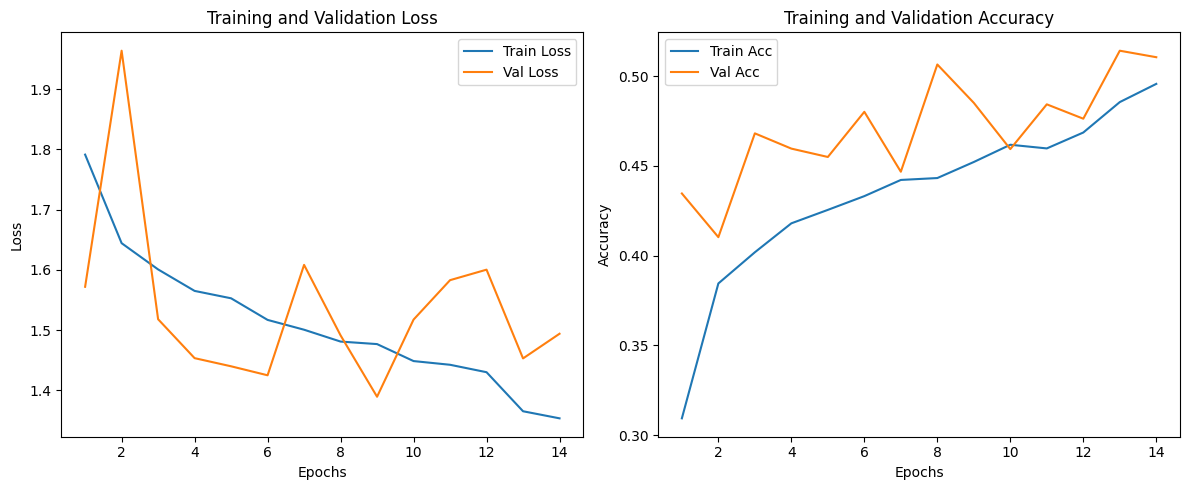

In [ ]:
# Plot training and validation curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Acc')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
classes = list(test_dataset.classes.values())
emotions = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
# test function
def test(model, dataloader):
    model.eval()

    # prepare to count predictions for each class
    correct_pred = defaultdict(int)
    total_pred = defaultdict(int)

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in tqdm(dataloader, desc="Testing...", total=len(dataloader)):
            images, labels = data['image'].to(device), data['label'].to(device)

            outputs = model(images)

            _, predictions = torch.max(outputs, 1)
            predictions = predictions.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            all_labels.extend(labels)
            all_predictions.extend(predictions)

            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    return correct_pred, total_pred, all_labels, all_predictions

correct_pred, total_pred, all_labels, all_predictions = test(model, test_dataloader)

Testing...:   0%|          | 0/57 [00:00<?, ?it/s]

# Facial Expression Classification Test Set Results

In [ ]:
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.4f}')

total_acc = sum(correct_pred[class_name] for class_name in classes) / len(test_dataset)
print(f"Total accuracy: {total_acc:.4f}")

Accuracy for class: Angry is 0.3136
Accuracy for class: Happy is 0.8282
Accuracy for class: Sad   is 0.2441
Accuracy for class: Neutral is 0.7364
Accuracy for class: Surprise is 0.7428
Accuracy for class: Disgust is 0.3818
Accuracy for class: Fear  is 0.1174
Total accuracy: 0.5238
